In [44]:
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import pandas as pd
import pydot

from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers.core import Activation
from keras.optimizers import SGD
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

## General methodology:
1. Load and inspect data
2. Transform data
3. Feature engineering
4. Set baseline accuracy/score
5. Hyper-parameter tuning
6. Regularization and over-fitting mitigation
7. rinse and repeat 3,5,6

Sources for some of the code: https://www.kaggle.com/arunkumarramanan/awesome-cv-with-fashion-mnist-classification

In [2]:
# Load the data
# Grab the train and test data sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

[9 0 0 3 0 2 7 2 5 5]
(60000, 28, 28)


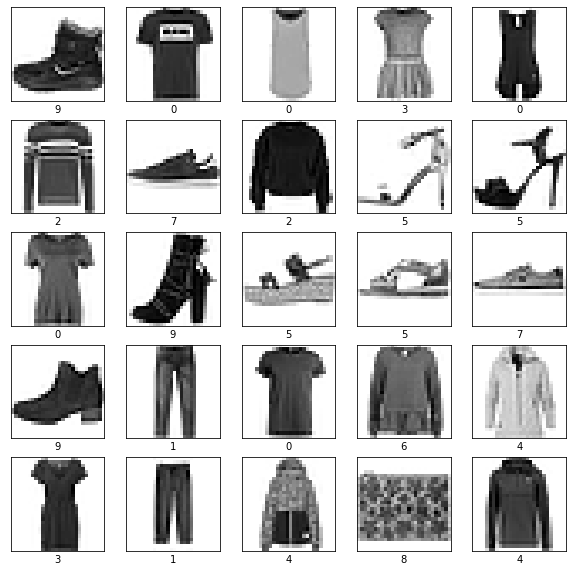

In [3]:
# Look at it
print(y_train[:10]) # Categorical data
print(X_train.shape)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

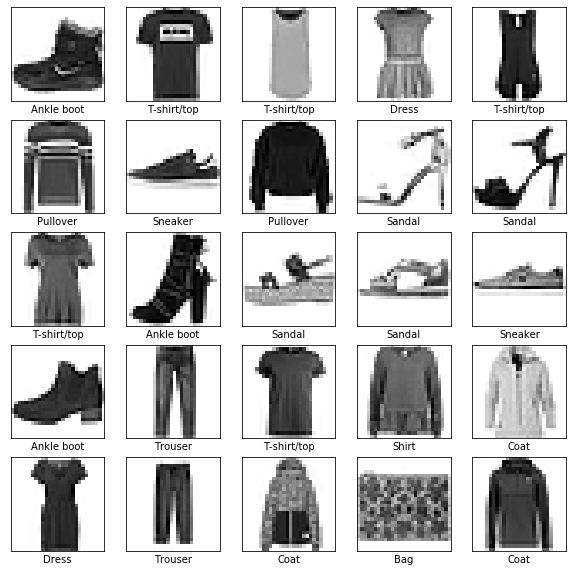

In [4]:
# Label the y data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

(60000, 28, 28)
(10000, 28, 28)


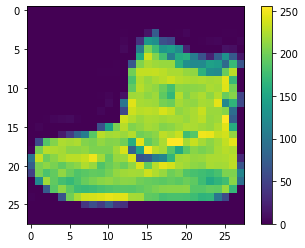

In [5]:
# Inspect shape of the feature data, as well as ranges:
print(X_train.shape)
print(X_test.shape)

# Look at ranges
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()


In [6]:
# Pre-processing

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train_df = pd.DataFrame(X_train)
print("Maximum value of X values: ", max(X_train_df.max()))

# normalize based on max value
# catch re-running exception where it's already normalized:
if max(X_train_df.max()) == 255.0:
    print("normalizing")
    X_train /= 255
    X_test /= 255
    
# Convert y to categorical outputs with one-hot encoding:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(y_train[0])

Maximum value of X values:  255.0
normalizing
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:
# Set a baseline (source: https://github.com/correll/deep-learning/blob/master/lecture/Lab%202%20A%20first%20Network%20in%20Keras.ipynb)
model = Sequential()
model.add(Dense(10, input_shape=(784,)))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['categorical_accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train and set baseline!
print(X_train.shape)
print(y_train[0])
history = model.fit(X_train, y_train, batch_size=48000, epochs=200, verbose=1, validation_split=0.2)

(60000, 784)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 0s 10us/step - loss: 2.4272 - categorical_accuracy: 0.0683 - val_loss: 2.3646 - val_categorical_accuracy: 0.0916
Epoch 2/200
48000/48000 [==============================] - 0s 7us/step - loss: 2.3635 - categorical_accuracy: 0.0909 - val_loss: 2.3115 - val_categorical_accuracy: 0.1177
Epoch 3/200
48000/48000 [==============================] - 0s 6us/step - loss: 2.3117 - categorical_accuracy: 0.1158 - val_loss: 2.2668 - val_categorical_accuracy: 0.1417
Epoch 4/200
48000/48000 [==============================] - 0s 6us/step - loss: 2.2679 - categorical_accuracy: 0.1416 - val_loss: 2.2282 - val_categorical_accuracy: 0.1687
Epoch 5/200
48000/48000 [==============================] - 0s 6us/step - loss: 2.2301 - categorical_accuracy: 0.1678 - val_loss: 2.1941 - val_categorical_accuracy: 0.1963
Epoch 6/200
48000/48000 [========================

In [138]:
# Baseline
score = model.evaluate(X_test, y_test, verbose=1)
print("Baseline test score:", score[0])
print('Baseline test accuracy:', score[1])

10000/10000 [==============================] - 0s 23us/step
Baseline test score: 1.093458674812317
Baseline test accuracy: 0.6632000207901001


In [139]:
# Baseline 2 (ideas from: https://www.kaggle.com/arunkumarramanan/awesome-cv-with-fashion-mnist-classification)

print(X_train.shape)

model = Sequential()
model.add(Dense(128, input_shape=(784,), activation=tf.nn.relu))
model.add(Dense(10, activation=tf.nn.softmax))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=SGD(, metrics=['categorical_accuracy'])

history_2 = model.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.2)

(60000, 784)
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_82 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 85us/step - loss: 0.5180 - categorical_accuracy: 0.8171 - val_loss: 0.4487 - val_categorical_accuracy: 0.8402
Epoch 2/5
48000/48000 [==============================] - 4s 82us/step - loss: 0.3878 - categorical_accuracy: 0.8613 - val_loss: 0.3906 - val_categorical_accuracy: 0.8612
Epoch 3/5
48000/48000 [==============================] - 3s 70us/step - loss: 0.3455 - categorical_accurac

In [140]:
# Baseline 2
score_2 = model.evaluate(X_test, y_test, verbose=1)
print("Baseline test score:", score_2[0])
print('Baseline test accuracy:', score_2[1])

10000/10000 [==============================] - 0s 28us/step
Baseline test score: 0.3761920022964478
Baseline test accuracy: 0.8676000237464905


## Summary of progress so far:
An increase in ~20% test accuracy by decreasing the number of epochs, changing the the optimizer to 'adam', and adding a first Dense layer of 128! Huzzah! Let's keep going.

## Do some hyper parameter tuning using Grid Search

Parameters available:
- batch size
- epochs
- drop out
- optimizers

In [144]:
# Search for the optimal hyperparameters using grid search (Source: https://medium.com/@masonrchildress/how-to-gridsearch-over-a-keras-neural-network-with-a-pipeline-51fbfb62185e)

# create model function
def create_model(optimizer='adam', dropout=0.1):
    model = Sequential()
    model.add(Dense(128, input_shape=(784,), activation=("relu")))
    model.add(Dense(10, activation=("softmax")))
    model.add(Dropout(dropout))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    return model

# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_model, verbose=1)

# Set grid search parameters:
optimizers = ['rmsprop', 'adam', SGD()]
epochs = [5, 50, 100]
dropout = [0.1, 0.2]
    

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs,  dropout=dropout)


# Use it!
grid = GridSearchCV(estimator=neural_network, cv=3, param_grid=hyperparameters)

grid_search_fit = grid.fit(X_train, y_train)


Epoch 1/5
40000/40000 [==============================] - 3s 82us/step - loss: 2.0729 - accuracy: 0.7340
Epoch 2/5
40000/40000 [==============================] - 3s 76us/step - loss: 1.9535 - accuracy: 0.7780
Epoch 3/5
40000/40000 [==============================] - 4s 103us/step - loss: 1.9090 - accuracy: 0.7894
Epoch 4/5
40000/40000 [==============================] - 3s 64us/step - loss: 1.8610 - accuracy: 0.7964 0s - loss:
Epoch 5/5
20000/20000 [==============================] - 1s 29us/step
Epoch 1/5
40000/40000 [==============================] - 3s 63us/step - loss: 2.0958 - accuracy: 0.7321
Epoch 2/5
40000/40000 [==============================] - 2s 58us/step - loss: 1.9038 - accuracy: 0.7778
Epoch 3/5
40000/40000 [==============================] - 5s 118us/step - loss: 1.9228 - accuracy: 0.7883
Epoch 4/5
40000/40000 [==============================] - 4s 105us/step - loss: 1.8883 - accuracy: 0.7953
Epoch 5/5
20000/20000 [==============================] - 1s 33us/step
Epoch 1/5
4000

In [162]:
# View the best parameters:
print("Best parameters ", grid_search_fit.best_params_)

print("Best accuracy score: ", grid_search_fit.best_score_)

# Predict test data:
y_pred = grid_search_fit.best_estimator_.predict(X_test)
y_pred = np_utils.to_categorical(y_pred, 10)

# Report results from test data:

def report_results(model, X, y, pred):        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average=None)
    prec = precision_score(y, pred, average=None)
    rec = recall_score(y, pred, average=None)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_search_fit.best_estimator_, X_test, y_test, y_pred)


Best parameters  {'dropout': 0.1, 'epochs': 100, 'optimizer': <keras.optimizers.SGD object at 0x1bfae3dd8>}
Best accuracy score:  0.8856666684150696
10000/10000 [==============================] - 0s 31us/step


{'f1': array([0.83949416, 0.97637004, 0.77330392, 0.88726919, 0.80072793,
        0.96226415, 0.6966649 , 0.95081967, 0.96430367, 0.96113074]),
 'acc': 0.8823,
 'precision': array([0.81723485, 0.9817998 , 0.86223862, 0.86294896, 0.7345576 ,
        0.9556213 , 0.74015748, 0.94471866, 0.96966633, 0.97043833]),
 'recall': array([0.863, 0.971, 0.701, 0.913, 0.88 , 0.969, 0.658, 0.957, 0.959,
        0.952])}

In [17]:
# Try the best model from class, but using grid search again to confirm the hyperparameters
# since this is a slightly different dataset and using dropout
# From "Deeplearning with Keras"

NB_CLASSES = 10 

model = Sequential()
# CONV => RELU => POOL
model.add(Dense(500, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dropout(0.1))
# a softmax classifier
model.add(Dense(NB_CLASSES))
model.add(Activation("softmax"))
# dropout
model.add(Dropout(0.1))
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])


history = model.fit(X_train, y_train,batch_size=128, epochs=30,verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)[1]
score


Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 3s 56us/step - loss: 2.0749 - accuracy: 0.7406 - val_loss: 0.4502 - val_accuracy: 0.8374
Epoch 2/30
48000/48000 [==============================] - 2s 51us/step - loss: 1.9543 - accuracy: 0.7783 - val_loss: 0.3876 - val_accuracy: 0.8591
Epoch 3/30
48000/48000 [==============================] - 2s 52us/step - loss: 1.8894 - accuracy: 0.7925 - val_loss: 0.3681 - val_accuracy: 0.8643
Epoch 4/30
48000/48000 [==============================] - 2s 50us/step - loss: 1.8750 - accuracy: 0.7991 - val_loss: 0.3550 - val_accuracy: 0.8717
Epoch 5/30
48000/48000 [==============================] - 2s 52us/step - loss: 1.8371 - accuracy: 0.8063 - val_loss: 0.3317 - val_accuracy: 0.8785
Epoch 6/30
48000/48000 [==============================] - 2s 52us/step - loss: 1.9057 - accuracy: 0.8069 - val_loss: 0.3255 - val_accuracy: 0.8817
Epoch 7/30
48000/48000 [==============================] - 2s 52us/st

0.8830999732017517

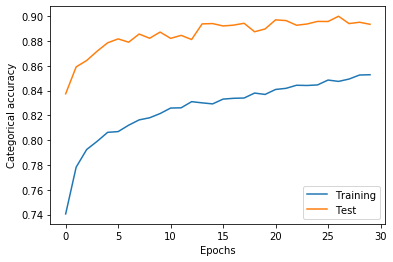

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

## Visualize it!

Test accuracy: 0.8830999732017517
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


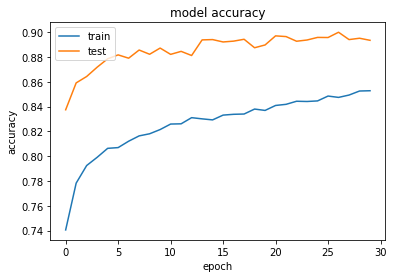

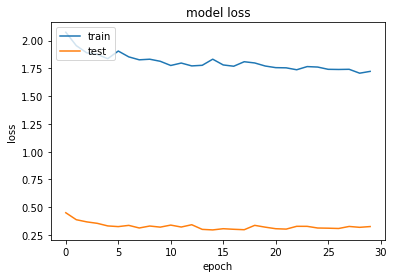

In [50]:

print('Test accuracy:', score)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()